In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os


def load_and_preprocess(folder_path):
  # Iterate through all the images in the folder
  for filename in os.listdir(folder_path):
      if filename.endswith(".png"):
          # Load the X-ray image
          image = Image.open(os.path.join(folder_path, filename))

          # Noise Reduction: Gaussian Blur
          blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

          # Edge Detection: Canny Edge Detector
          edges = cv2.Canny(blurred_image, 50, 150)

          # Find contours
          contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          # Draw contours on a blank image
          contour_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
          cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

          roi = contour_img[14:255 , 20:282]

          return roi

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from skimage.feature import hog
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from scipy import ndimage


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

learning_rate = 0.0001
# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=5)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_path = "/content/drive/MyDrive/Train_withoutMask"
test_path = "/content/drive/MyDrive/Test_withoutMask"

batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=load_and_preprocess(train_path)
)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=load_and_preprocess(test_path))

# Train/validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',

)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[es]
)

Epoch 1/10
50/50 [==============================] - 372s 7s/step - loss: 2.5833 - accuracy: 0.9075 - val_loss: 0.4637 - val_accuracy: 0.9271
Epoch 2/10
50/50 [==============================] - 162s 3s/step - loss: 0.3526 - accuracy: 0.9469 - val_loss: 0.5944 - val_accuracy: 0.9297
Epoch 3/10
50/50 [==============================] - 156s 3s/step - loss: 0.2506 - accuracy: 0.9569 - val_loss: 0.4858 - val_accuracy: 0.9193
Epoch 4/10
50/50 [==============================] - 161s 3s/step - loss: 0.1653 - accuracy: 0.9663 - val_loss: 0.2240 - val_accuracy: 0.9401
Epoch 5/10
50/50 [==============================] - 144s 3s/step - loss: 0.1493 - accuracy: 0.9631 - val_loss: 0.3514 - val_accuracy: 0.9193
Epoch 6/10
50/50 [==============================] - 143s 3s/step - loss: 0.1461 - accuracy: 0.9631 - val_loss: 0.1819 - val_accuracy: 0.9531
Epoch 7/10
50/50 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9638Epoch 7: early stopping


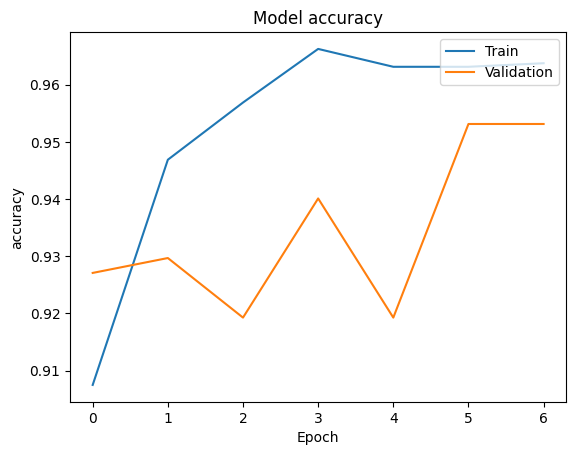

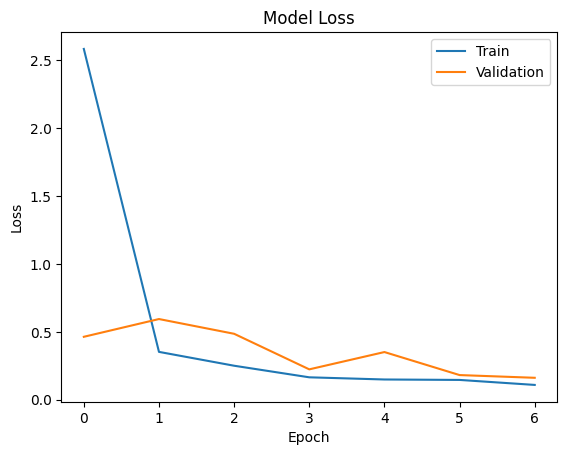

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
drive_path = '/content/drive/My Drive/'
model.save(drive_path+'ROI_mobilenetV2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_binary)
class_report = classification_report(y_true, y_pred_binary)
print("Classification Report:\n", class_report)

7/7 [==============================] - 52s 8s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.54      0.53       100
           1       0.53      0.52      0.53       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



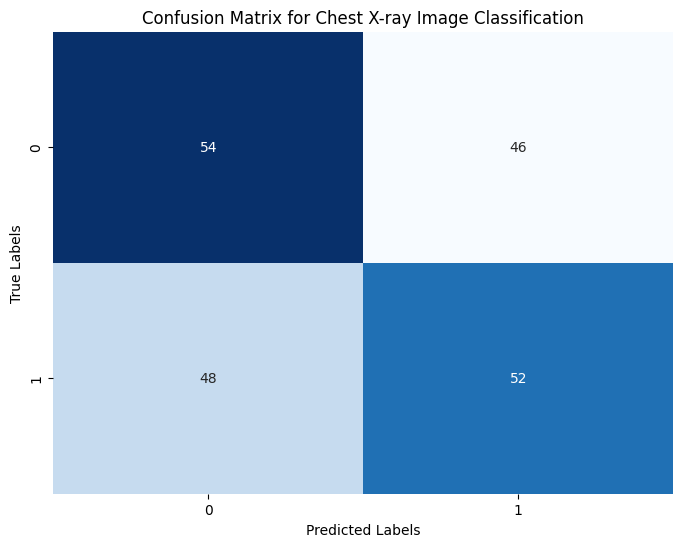

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Chest X-ray Image Classification')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image  # Assuming using TensorFlow
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import os

# Load the pre-trained model
#model = load_model("your_model.h5")  # Replace with your model filename

# Define function to predict on an image
def predict_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed by your model
  img = image.img_to_array(img)
  img = img / 255.0  # Normalize image (assuming model expects normalized input)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  pred = model.predict(img)[0][0]  # Get probability for positive class

  if pred > 0.5:  # Adjust threshold as needed
    return "COVID-19 Positive ({:.2f}%)".format(pred * 100)
  else:
    return "COVID-19 Negative ({:.2f}%)".format((1 - pred) * 100)

# Specify the folder containing test images
test_folder = "/content/drive/MyDrive/Test_withoutMask/normal/Normal-1085.png"
predict_image(test_folder)

1/1 [==============================] - 1s 1s/step


'COVID-19 Negative (100.00%)'

In [ ]:
from tensorflow.keras.preprocessing import image  # Assuming using TensorFlow
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import os

# Load the pre-trained model
#model = load_model("your_model.h5")  # Replace with your model filename

# Define function to predict on an image
def predict_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed by your model
  img = image.img_to_array(img)
  img = img / 255.0  # Normalize image (assuming model expects normalized input)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  pred = model.predict(img)[0][0]  # Get probability for positive class

  if pred > 0.5:  # Adjust threshold as needed
    return "COVID-19 Positive ({:.2f}%)".format(pred * 100)
  else:
    return "COVID-19 Negative ({:.2f}%)".format((1 - pred) * 100)

# Specify the folder containing test images
test_folder = "/content/drive/MyDrive/Test_withoutMask/Covid/COVID-1009.png"
predict_image(test_folder)

1/1 [==============================] - 0s 110ms/step


'COVID-19 Positive (99.82%)'